In [1]:
import time
startTime = time.time()

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, nquad, dblquad
from scipy.special import ellipe, ellipk
from scipy.interpolate import lagrange, InterpolatedUnivariateSpline
from scipy.signal import savgol_filter

## User input

In [2]:
# Gas:
# Conversion to linear scale was made in the notebook: grav_project/NGC_5005/Gas_from_mass_surface_density.ipynb
raddens = "../data/gasmsd_kpc_linear.txt"      # Gas density with 2 columns, units: KPC, MSUN/PC^2
maxkpc=11
minkpc=.9473
# Parameters
z0 = 0.93

#constants
G = 0.00000431158                   # Gravitational constant (KPC/MSUN*(KM/S)^2)  

In [3]:
# Gas
tracedgas = np.loadtxt("../NGC_5005/traced_data/ngc5005_gas.txt")
radii, tracedgas_v = tracedgas.T
radii = radii[1:]
tracedgas_v = tracedgas_v[1:]

## Density profile, outputs: radii (array), densities (array), rcut (one #), delta (one #)

In [4]:
def DensityProfile(raddens=raddens):
    mudata = np.loadtxt(raddens)     
    xdinp, ydinp = mudata.T
    rcut = xdinp[len(xdinp)-1]               # rcut is the LAST radius value (?)
    delta = rcut - xdinp[len(xdinp)-2]       # difference between the last two radius values
    
    return xdinp, ydinp, rcut, delta

#defining these output values:
# Radius
xdinp = DensityProfile()[0]
# Density
ydinp = DensityProfile()[1]
# Cutoff radius
rcut = DensityProfile()[2]
# Cutoff length
delta = DensityProfile()[3]

## Interpolation

In [5]:
def interpd(x,y):
    #return lagrange(x,y)                # Lagrange interpolation didn't work well so I used Univariate Spline
    return InterpolatedUnivariateSpline(x,y,k=4)
    
# Calculate the density values at the sampling radii
spline_rhor = interpd(xdinp,ydinp)        # define the polynomial that's calculated

radii = np.arange(0.001,11,0.1)                # Sampling radii
## Partial derivative / Smoothing

In [6]:
#radii = np.linspace(0.001,maxkpc,100)                # Sampling radii
#radii = np.arange(minkpc,maxkpc,0.1)                # Sampling radii

# Partial derivative of rho(u,z) with respect to u
# Taking the derivative of the splined polynomial (radius and density values, rho(r) or rho(u))
drho_du = spline_rhor.derivative()

# Evaluating at given radii
drho_du_values = drho_du(radii)

# Smoothing: Savitzky-Golay filter: https://riptutorial.com/scipy/example/15878/using-a-savitzky-golay-filter
drho_du_smooth = savgol_filter(drho_du_values, 11, 5)  # window size 11, polynomial order 6

# Spline the smoothed derivative
spline_drhor = interpd(radii,drho_du_smooth)

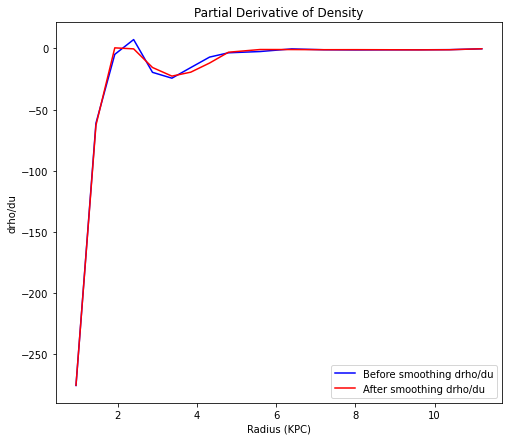

In [7]:
# Plot 
plt.figure(figsize=(8,7))
plt.plot(radii,drho_du_values, label="Before smoothing drho/du", c="blue")
plt.plot(radii,drho_du_smooth, label="After smoothing drho/du", c="red")
#plt.plot(radii,spline_drhor(radii), label="After smoothing and splining drho/du", c="purple")
plt.title("Partial Derivative of Density")
plt.xlabel("Radius (KPC)")
plt.ylabel("drho/du")
plt.legend()
plt.show()

## Functions

In [8]:
#from casertano http://articles.adsabs.harvard.edu/pdf/1983MNRAS.203..735C
# Casertano Eq 2
def drho_du(z,u):
    return spline_drhor(u) * np.cosh(z /z0)**(-2)

print(drho_du(1,1))

-90.77944368790979


In [9]:
# Casertano Eq 5
def px(z,u,r):
    x = (r**2 + u**2 + z**2)/(2*r*u)
    return x - np.sqrt((x**2)-1)

print(px(1,1,1))

0.3819660112501051


In [10]:
# Complete elliptic integral
def K_E(z,u,r):
    return ellipk(px(z,u,r)) - ellipe(px(z,u,r))

print(K_E(1,1,1))


0.35734399698214614


In [13]:
#casertano eq 4, simplified
integrand = lambda z,u,r:(8 *G) * drho_du(u,z) * K_E(z,u,r) / np.sqrt(u/(r * px(z,u,r)))

print(integrand(1,1,1))

-0.0006915328307731284


In [18]:
# Define minimum and maximum values of radius for integration
intmin = 0.01 #0 causes runtime issues but this gets very close
intmax = 1e3 #np.max(radii) #Integration is from 0 to infinity but infinity gives overflow errors so we just pick the largest we can without causing errors

# Reverse order of variables to setup for integration
radialforce = lambda r: dblquad(integrand, intmin, intmax,lambda u:intmin,lambda u:intmax, args=(r))
print(radialforce)
print(radialforce(1))
radialforce = np.vectorize(radialforce)
print(radialforce)
print(radialforce(radii))

<function <lambda> at 0x00000297319E9A60>


TypeError: integrate() argument after * must be an iterable, not int

## Velocity

In [ ]:
#casertano eq 6:
print(radii)
velocs = (radii*radialforce(radii))**(0.5)
scale = 1
velocs=velocs*scale
print(velocs)

## More troubleshooting: comparing the F(r) functions

In [ ]:
tracedgas_F=tracedgas_v**2/-radii

In [ ]:
plt.figure(figsize=(8,6))             
plt.scatter(radii,scale*np.asarray(radialforce(radii)), linestyle='solid', label='Scaled calculated gas Force by {}'.format(scale))
plt.scatter(radii, tracedgas_F, label='Expected Gas Force', c='red')
plt.legend(fontsize=10)

## Plot

In [ ]:
scale=.01
actvelocs=scale*np.asarray(velocs)
plt.figure(figsize=(8,6))             
plt.scatter(radii, actvelocs, linestyle='solid', label='Scaled calculated gas velocity by {}'.format(scale))
#plt.plot(radii, 1e3*velocs_smooth, linestyle='solid', label='Smoothed Gas Velocity')
plt.scatter(radii, tracedgas_v, label='Expected Gas Velocity', c='red')
plt.axis('tight');
plt.title('NGC 5005')
plt.xlabel('Radius (KPC)', fontsize=10)
plt.ylabel('Velocity (KM/S)', fontsize=10)
plt.legend(fontsize=10)
#plt.xlim(0,12)
plt.show()
print(actvelocs)
print(tracedgas_v)
print(radii)

In [ ]:

executionTime = (time.time() - startTime)
print('Execution time in minutes: ' + str(executionTime/60))